<a href="https://colab.research.google.com/github/tomoyukiharada/Kaggle-team/blob/team1/kaggle_taitanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#ライブラリーのインポート
!pip install kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
#データの読み込み
df = pd.read_csv('train.csv')
# #データの確認
# print(df.dtypes)
# print(len(df['Survived']))
# print(df.isnull().sum())

"""
データの総数891に対し、Cabinの欠損値は687個より削除
またチケットも削除する
"""
#データの列を削除
df = df.drop(['Cabin','Ticket'],axis=1)
#enbarkedの欠損値処理
df = df.dropna(subset=['Embarked'])
#年齢の欠損値処理
df['Age'] = df['Age'].fillna(df['Age'].mean())

# print(len(df['Survived']))
# print(df.isnull().sum())

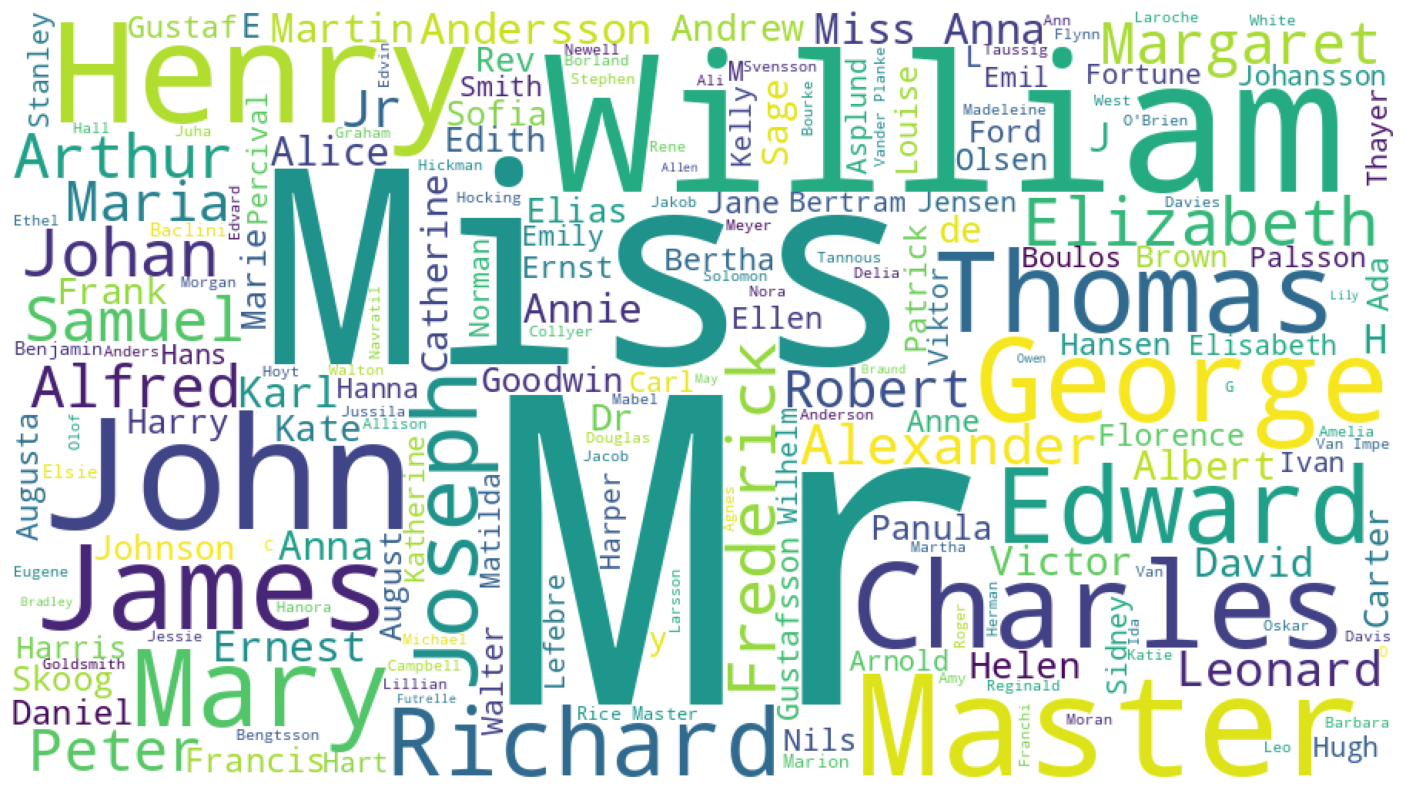

In [ ]:
list = []
for name_list in df['Name']:
  for name in name_list.split(','):
    list.append(name)

from wordcloud import WordCloud
%matplotlib inline
wc = WordCloud(background_color="white",width=900, height=500).generate(' '.join(list))
plt.figure(figsize=(18,10))
plt.axis("off")
plt.imshow(wc)

In [ ]:
#name
"""
map()関数　リストやタプルなどの各地に対して指定した関数を使うことが可能

.agg() メソッド：

グループごとの集計:
.groupby() と組み合わせて、特定の列（または複数の列）でグループ化した後に、
各グループごとに統計量を計算
複数の統計量を同時に計算:
.agg() は、複数の統計量を同時に計算できるため、
一度の操作で複数の結果を取得
"""
df['name'] = df['Name'].map(lambda x:x.split(',')[1].split('.')[0])
df['Survived'].groupby(df['name']).agg(['mean', 'count'])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,name
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [ ]:
#ダミー変数の生成
df = pd.get_dummies(df,columns=['Sex','Embarked','name'])

<Axes: >

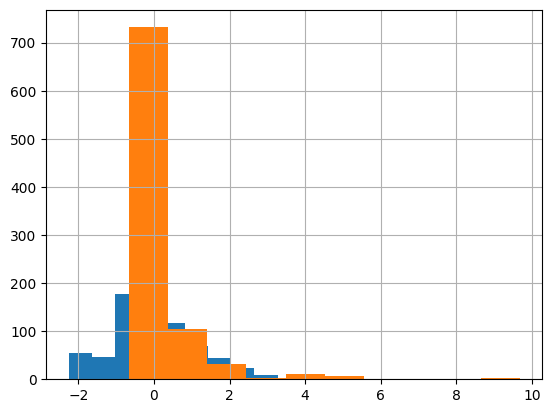

In [ ]:
#AgeとFareのみを標準化
scaler = StandardScaler()
scaler.fit(df[['Age','Fare']])
df[['Age_std','Fare_std']] = scaler.transform(df[['Age','Fare']])
df['Age_std'].hist()
df['Fare_std'].hist()

<Axes: >

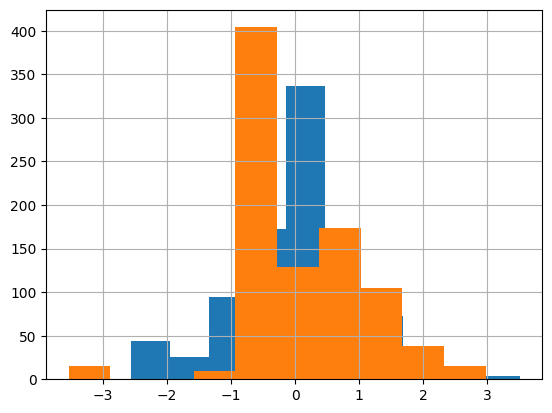

In [ ]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
#第一かっこは[]リストを作成　第二かっこはデータフレームを作成
pt.fit(df[['Age','Fare']])
df[['Age_box','Fare_box']] = pt.transform(df[['Age','Fare']])
df['Age_box'].hist()
df['Fare_box'].hist()

In [ ]:
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'name_ Capt', 'name_ Col', 'name_ Don', 'name_ Dr',
       'name_ Jonkheer', 'name_ Lady', 'name_ Major', 'name_ Master',
       'name_ Miss', 'name_ Mlle', 'name_ Mme', 'name_ Mr', 'name_ Mrs',
       'name_ Ms', 'name_ Rev', 'name_ Sir', 'name_ the Countess', 'Age_std',
       'Fare_std', 'Age_box', 'Fare_box'],
      dtype='object')


In [ ]:
#SurvivedとSexの関連性
df.groupby('Survived')['Sex_male'].value_counts()

Survived  Sex_male
0         True        468
          False        81
1         False       231
          True        109
Name: count, dtype: int64

In [ ]:
#SurvivedとPclassの関連性
df.groupby('Survived')['Pclass'].value_counts()

Survived  Pclass
0         3         372
          2          97
          1          80
1         1         134
          3         119
          2          87
Name: count, dtype: int64

Survived  Sex  
0         True     468
          False     81
1         False    231
          True     109
Name: count, dtype: int64

In [ ]:
#SurvivedとSibSp・Parchの関連性
#あまり同行者数は関係なさそう
df.groupby('Survived')['SibSp'].value_counts()
df.groupby('Survived')['Parch'].value_counts()


Survived  Parch
0         0        445
          1         53
          2         40
          4          4
          5          4
          3          2
          6          1
1         0        231
          1         65
          2         40
          3          3
          5          1
Name: count, dtype: int64

<Axes: xlabel='Family', ylabel='count'>

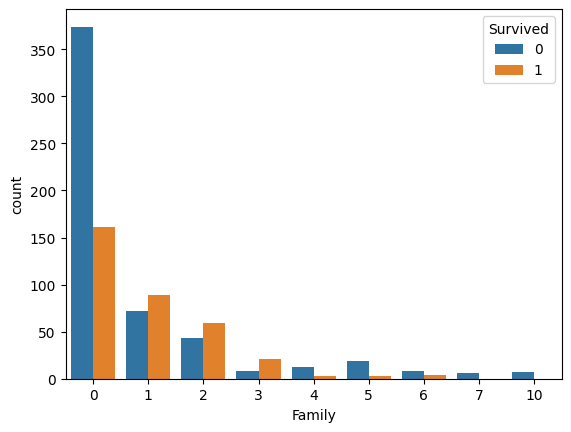

In [ ]:
#ファミリーサイズに拡張
df['Family'] = df['SibSp'] + df['Parch']
df.groupby('Survived')['Family'].value_counts()
sns.countplot(x='Family', hue='Survived', data=df)

In [ ]:
# FamilySizeを離散化してカテゴリー変数を作成
df['family_class'] = 0
df.loc[(df['Family'] >= 1) & (df['Family'] <= 3), 'family_class'] = 1
df.loc[df['Family'] >= 4, 'family_class'] = 2

In [ ]:
df.groupby('Survived')['Embarked_Q'].value_counts()
df.groupby('Survived')['Embarked_S'].value_counts()

Survived  Embarked_Q
0         False         502
          True           47
1         False         310
          True           30
Name: count, dtype: int64

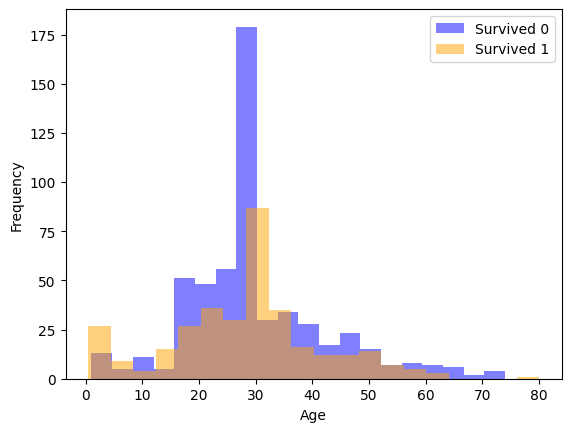

In [ ]:
#SurvivedとAgeの関連性
# データの分割
survived_0 = df[df['Survived'] == 0]['Age']
survived_1 = df[df['Survived'] == 1]['Age']

# ヒストグラムの作成
plt.hist(survived_0, bins=20, alpha=0.5, label='Survived 0', color='blue')
plt.hist(survived_1, bins=20, alpha=0.5, label='Survived 1', color='orange')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

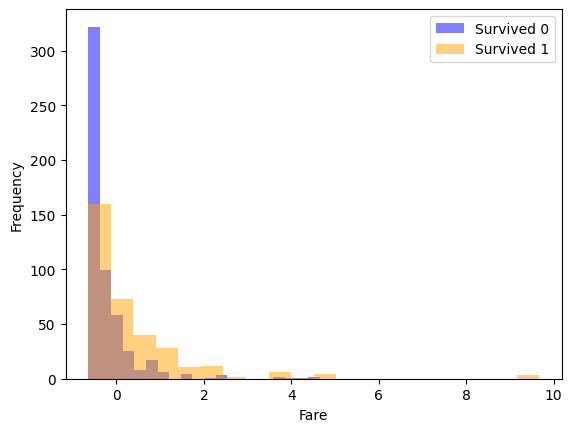

In [ ]:
# Fareとの関連性
# データの分割
survived_0 = df[df['Survived'] == 0]['Fare']
survived_1 = df[df['Survived'] == 1]['Fare']

# ヒストグラムの作成
plt.hist(survived_0, bins=20, alpha=0.5, label='Survived 0', color='blue')
plt.hist(survived_1, bins=20, alpha=0.5, label='Survived 1', color='orange')

plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,...,name_ Mr,name_ Mrs,name_ Ms,name_ Rev,name_ Sir,name_ the Countess,Age_std,Fare_std,Age_box,Fare_box
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,True,False,...,True,False,False,False,False,False,-0.589620,-0.500240,-0.553486,-0.876580
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,False,False,...,False,True,False,False,False,False,0.644848,0.788947,0.662862,1.341242
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,False,False,...,False,False,False,False,False,False,-0.281003,-0.486650,-0.238126,-0.787660
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,False,False,...,False,True,False,False,False,False,0.413385,0.422861,0.442966,1.071865
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,True,False,...,True,False,False,False,False,False,0.413385,-0.484133,0.442966,-0.772006


In [ ]:
X = df.drop(['Survived','Family','Name','Age','Fare','Age_std','Fare_std','SibSp','Parch','Sex_male','Embarked_Q'],axis=1)
y = df[['Survived']]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
print(X.columns)


Index(['PassengerId', 'Pclass', 'Sex_female', 'Embarked_C', 'Embarked_S',
       'name_ Capt', 'name_ Col', 'name_ Don', 'name_ Dr', 'name_ Jonkheer',
       'name_ Lady', 'name_ Major', 'name_ Master', 'name_ Miss', 'name_ Mlle',
       'name_ Mme', 'name_ Mr', 'name_ Mrs', 'name_ Ms', 'name_ Rev',
       'name_ Sir', 'name_ the Countess', 'Age_box', 'Fare_box',
       'family_class'],
      dtype='object')


In [ ]:
#線形判別
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)
lda.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7802690582959642

In [ ]:
#ロジスティック回帰
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7757847533632287

In [ ]:
#最近傍法
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.5560538116591929

In [ ]:
#ランダムフォレスト
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc.score(X_test,y_test)

<ipython-input-42-dae3fb359a3f>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)


0.7892376681614349

In [ ]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
gbc.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7757847533632287

In [ ]:
#名前から予測を立てる

